<h1 align="center">Image Partition and Color Reduction</h1>
<h5 align="center">Constructing diffusion map using the Nyström method v1.</h5>

## Nyström method
For a positive definite matrix 
$Q = \left[\begin{matrix}
A & B^T  \\
B & C \\
\end{matrix}\right] $,
$$ Q \approx \left[\begin{matrix} A \\B \end{matrix}\right] A^{-1} \left[\begin{matrix} A & B^T \end{matrix}\right].$$



## Framework

1. ***Construct the submatrix of the affinity matrix $K$***  
Construct only the randomly chose $sam$ columns of $K$, where $sam$ is a small number not larger than 20.


2. ***Construct the Cholesky factor $F$ of the normalized affinity matrix $Q$***  
Using the Nyström method and the Cholesky decomposition (suggested by [1]), 
$$Q \approx FF^{T} \text{, where } F:= \left[\begin{matrix} A \\B \end{matrix}\right] A^{-1/2}.$$


3. ***Compute the approximated eigenvalues and eigenvectors of the diffusion matrix***  
The eigenvalues of diffusion matrix are the square root of eigenvalues of $F$.  
The eigenvectors of diffusion matrix can be obtained by multiply a diagonal matrix on the left side of eigenvectors of $F$.


4. ***Construct the diffusion map $Y$***


5. ***Cluster via k-means***



*Need details of constructing the diffusion map? See [here](https://github.com/yujieho/Diffusion_Maps).*

## Implementation

### 1. Import libraries

In [1]:
%pylab inline
import cv2
from itertools import product
from scipy.spatial.distance import cdist
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### 2. Load image

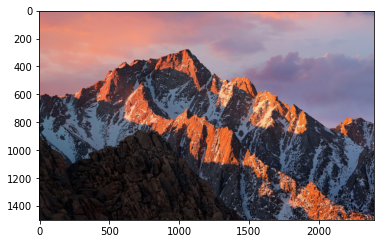

Size of figure:  1500 * 2400


In [2]:
img = cv2.imread('images/view3.jpg')
img = img[:,:,::-1]

#normalize the RGB code
img = img/255

#show image
plt.imshow(img)
plt.show()

#size
x, y, z = img.shape
n = x*y
print('Size of figure: ', x,'*',y)

### 3. Define functions

In [3]:
#construct a diffusion map

def dm():
    rand=calsam()       #randomly picked samples
    K=mk(rand)   #affinity matrix
    D, Dsmall=md(K)
    Q=mq(K, Dsmall, D)  #normalized affinity matrix
    L, eigvec=eign(Q, D)   #eigenvalues and eigenvectors of diffusion matrix
    Y=my(L, eigvec, rand)  #diffusion map
    
    return Y

In [4]:
#using K-means to cluster data in the diffusion space

def km(Y):
    kmeans=KMeans(clusters)
    kmeans=kmeans.fit(Y)
    labels=array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

In [5]:
def calsam():
    return sort(permutation(n)[:sam])

In [6]:
def mk(rand):
    #distance matrix
    dist=vstack([cdist(datav[rand,:],datav[rand,:]), 
                 cdist(delete(datav,rand,axis=0),datav[rand,:])])
    
    #local scaling
    dist_sort=sort(dist, axis=0)    
    sigma=dist_sort[s+1,:]
    sigma[argwhere(sigma==0)]=10000
    sigmasmall=diag(1/sigma)
    
    dist_sort=sort(dist, axis=1)
    sigma=hstack([sigma,dist_sort[sam:,s+1]])
    sigma[argwhere(sigma==0)]=10000
    sigma=sparse.dia_matrix((1/sigma,0), shape=(n,n))
    
    return exp( -sigma.dot(dist).dot(sigmasmall) )    #Affinity matrix

In [7]:
def md(K):
    Dsmall=diag(1/sqrt(sum(K[:sam,:sam],axis=1)))
    D=sparse.dia_matrix((1/sqrt(sum(K,axis=1)),0), shape=(n,n))
    
    return D, Dsmall

In [8]:
def mq(K, Dsmall, D):
    return D.dot(K).dot(Dsmall)

In [9]:
def eign(Q, D):
    uu, ul, uv=svd(Q[:sam,:])
    ul=diag(ul**(-1/2))
    Asi=uu.dot(ul).dot(uv)
    
    F=Q.dot(Asi)

    U, L, V=svds(F, dim)

    L=diag(sqrt(L[::-1]))
    eigvec=D.dot(U[:,::-1])
    
    return L, eigvec

In [10]:
def my(L, eigvec, rand):
    Y=eigvec.dot(L)
    
    #reorder data
    for i in range(sam):
        Y=insert(Y, rand[sam-1-i]+1, Y[sam-1-i], axis=0)
        Y=delete(Y, sam-1, axis=0)
    
    return Y

### 4. Set parameters

In [11]:
sam=10        #number of sample points to compute
s=7           #local scaling parameter
dim=3         #embedding dimension
clusters=15   #reduce image into how many colors

### 5. Calculate the diffusion map and labeling

In [12]:
%%time

datav=img.reshape(n, z)
Y=dm()

CPU times: user 9.85 s, sys: 4.25 s, total: 14.1 s
Wall time: 14.6 s


In [13]:
%%time

labels=km(Y)

CPU times: user 3min 21s, sys: 12.5 s, total: 3min 33s
Wall time: 1min 25s


### 6. Display result

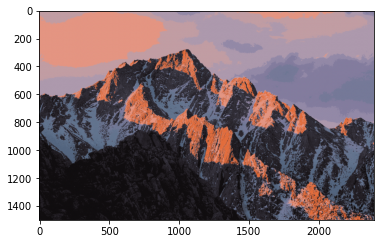

Using 10 sample points.
Using 15 colors.


In [14]:
#calculate colors
colorrgb=[]
for i,j in product(range(clusters), range(z)):
    colorrgb.append(percentile( datav[argwhere(labels==i)[:,0],j],50 ))

#show image
imc=zeros((n,z))
for i in range(clusters): imc[argwhere(labels==i)[:,0],:]=colorrgb[3*i:3*i+3]
imc = imc.reshape(x,y,z)

plt.imshow(imc)
plt.show()

print('Using', sam, 'sample points.')
print('Using', clusters, 'colors.')

matplotlib.image.imsave('results/IP_DM_Nystrom_v1/view3_10sam15color.jpg', imc)

### References

[1] [Diffusion Maps Meet Nystrom](https://arxiv.org/abs/1802.08762)  
[2] [Spectral grouping using the Nystrom method](https://escholarship.org/uc/item/29z29233)